# Exploratory Data Analysis

### Mounting Google Drive to Access the required files uploaded in *Drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting Up the environment for working with Apache Spark in Google Colab

In [2]:
!ls /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

/content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz


## Base imports -- *External Libraries!*
---
Libraries that are used in this project

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, mean, stddev, sum, first
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
# import pandas as pd

### Creating the Spark Session

In [4]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder \
                    .master("local") \
                    .appName("PhishingAnalysis") \
                    .config('spark.ui.port', '4050')\
                    .getOrCreate()

### Creating Symbolic Link of Goole Drive Folder to Session Storage `/content/data` in order to access them


In [5]:
!mkdir /content/data
!ln -s /content/drive/MyDrive/DA231/Project/Data/* /content/data/

## Loading the Dataset
### About the Dataset
----
The dataset focuses on various attributes of URLs to identify potential phishing attempts. It includes features such as URL length, domain characteristics, security indicators (like HTTPS usage), and content structure metrics. By analyzing these attributes, the dataset aims to differentiate between legitimate and malicious URLs, providing valuable insights for cybersecurity efforts. This information can be crucial for developing models to detect phishing threats effectively.

In [6]:
df = spark.read.csv("/content/data/phishing_urls.txt", header=True, inferSchema=True)

## Summary of the DataSet


Schema and Summary of the Data Set

In [7]:
df.printSchema()

root
 |-- FILENAME: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- URLLength: integer (nullable = true)
 |-- Domain: string (nullable = true)
 |-- DomainLength: integer (nullable = true)
 |-- IsDomainIP: integer (nullable = true)
 |-- TLD: string (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- TLDLength: integer (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- HasObfuscation: integer (nullable = true)
 |-- NoOfObfuscatedChar: integer (nullable = true)
 |-- ObfuscationRatio: double (nullable = true)
 |-- NoOfLettersInURL: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- NoOfDegitsInURL: integer (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- NoOfEqualsInURL: integer (nullable = true)
 |-- NoOfQMarkInURL: integer (nullable = true)
 |

In [8]:
df.describe().show()

+-------+------------+--------------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+--------------------+-------------------+--------------------+-------------------+--------------------------+---------------------+-------------------+------------------+------------------+------------------+--------------------+---------------------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+---------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+---------

In [9]:
# Summary of key statistics for the dataset
def summarize_data(df):
    summary = {}
    summary['Total Rows'] = df.count()
    summary['Total Columns'] = len(df.columns)
    summary['Missing Values'] = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().sum().sum()
    summary['Duplicate Rows'] = df.dropDuplicates().count() - df.count()
    summary['Data Types'] = df.dtypes
    return summary

print(summarize_data(df))

{'Total Rows': 235795, 'Total Columns': 56, 'Missing Values': 0, 'Duplicate Rows': 0, 'Data Types': [('FILENAME', 'string'), ('URL', 'string'), ('URLLength', 'int'), ('Domain', 'string'), ('DomainLength', 'int'), ('IsDomainIP', 'int'), ('TLD', 'string'), ('URLSimilarityIndex', 'double'), ('CharContinuationRate', 'double'), ('TLDLegitimateProb', 'double'), ('URLCharProb', 'double'), ('TLDLength', 'int'), ('NoOfSubDomain', 'int'), ('HasObfuscation', 'int'), ('NoOfObfuscatedChar', 'int'), ('ObfuscationRatio', 'double'), ('NoOfLettersInURL', 'int'), ('LetterRatioInURL', 'double'), ('NoOfDegitsInURL', 'int'), ('DegitRatioInURL', 'double'), ('NoOfEqualsInURL', 'int'), ('NoOfQMarkInURL', 'int'), ('NoOfAmpersandInURL', 'int'), ('NoOfOtherSpecialCharsInURL', 'int'), ('SpacialCharRatioInURL', 'double'), ('IsHTTPS', 'int'), ('LineOfCode', 'int'), ('LargestLineLength', 'int'), ('HasTitle', 'int'), ('Title', 'string'), ('DomainTitleMatchScore', 'double'), ('URLTitleMatchScore', 'double'), ('HasFavi

##
Correlation Matrix

A correlation matrix is a table that shows the correlation coefficients between multiple variables, indicating the strength and direction of their relationships. Values range from -1 to +1, where -1 signifies a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 means no correlation. This matrix is a valuable tool in data analysis for identifying patterns and dependencies among variables.

### Potential groupings of the most relevant numeric columns

### 1. URL Characteristics

This is a table that displays the correlation coefficients between below selected variables. This matrix helps to identify the strength and direction of relationships among the URL features, indicating how changes in one characteristic may relate to changes in another, which is crucial for analyzing patterns in phishing URLs.

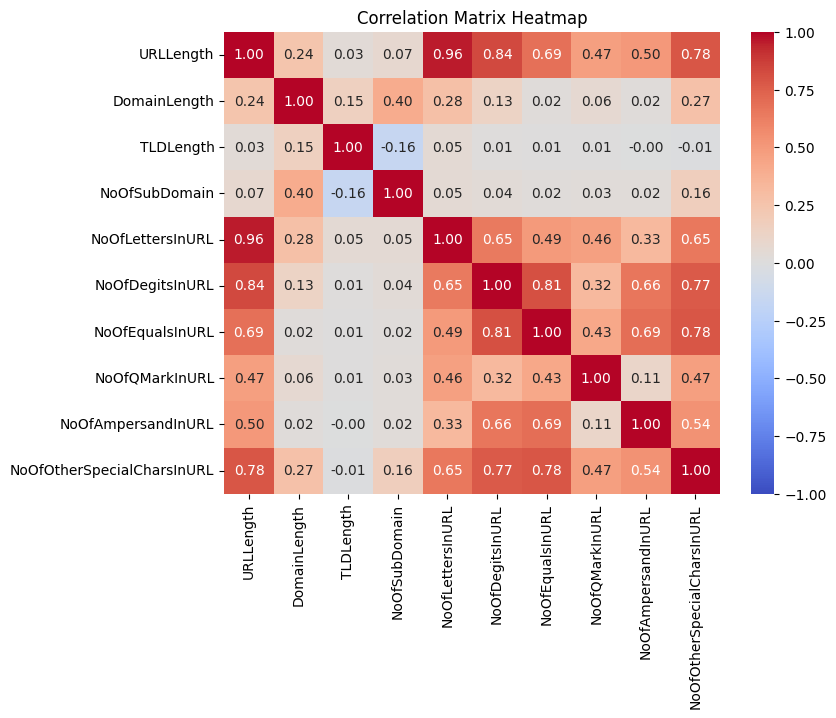

In [10]:
url_characteristics = [
    'URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain',
    'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL',
    'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL'
]

assembler = VectorAssembler(inputCols=url_characteristics, outputCol='features')
assembled_df = assembler.transform(df)

# Compute the correlation matrix
corr_matrix = Correlation.corr(assembled_df, 'features', method='pearson').head()[0]

# Convert the correlation matrix to a dense numpy array for plotting
correlation_matrix = corr_matrix.toArray()

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            xticklabels=url_characteristics, yticklabels=url_characteristics)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 2. URL Legitimacy Indicators

This is a table that displays the correlation coefficients between below selected features. It helps to identify the strength and direction of relationships among the indicators that assess the legitimacy of URLs, providing insights into how various characteristics may influence the likelihood of a URL being legitimate or malicious.

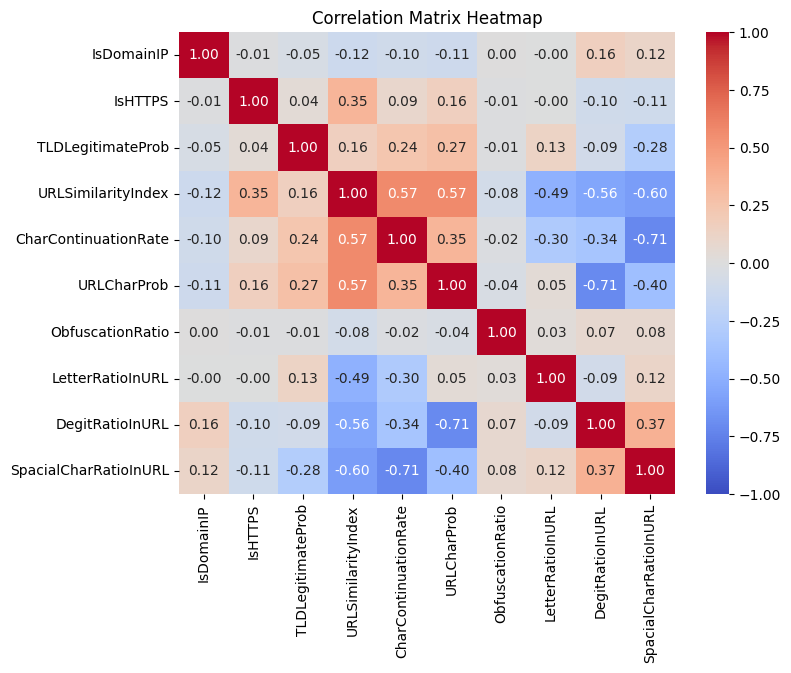

In [11]:
# URL Legitimacy Indicators
url_legitimacy_indicators = [
    'IsDomainIP', 'IsHTTPS', 'TLDLegitimateProb', 'URLSimilarityIndex',
    'CharContinuationRate', 'URLCharProb', 'ObfuscationRatio',
    'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL'
]
assembler = VectorAssembler(inputCols=url_legitimacy_indicators, outputCol='features')
assembled_df = assembler.transform(df)

# Compute the correlation matrix
corr_matrix = Correlation.corr(assembled_df, 'features', method='pearson').head()[0]

# Convert the correlation matrix to a dense numpy array for plotting
correlation_matrix = corr_matrix.toArray()

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            xticklabels=url_legitimacy_indicators, yticklabels=url_legitimacy_indicators)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 3. Web Page Content

This is a table that displays the correlation coefficients between below selected metrics. This matrix helps to identify the strength and direction of relationships among the characteristics that describe a webpage’s content and structure, providing insights into how these factors may influence usability, performance, and potential security risks.

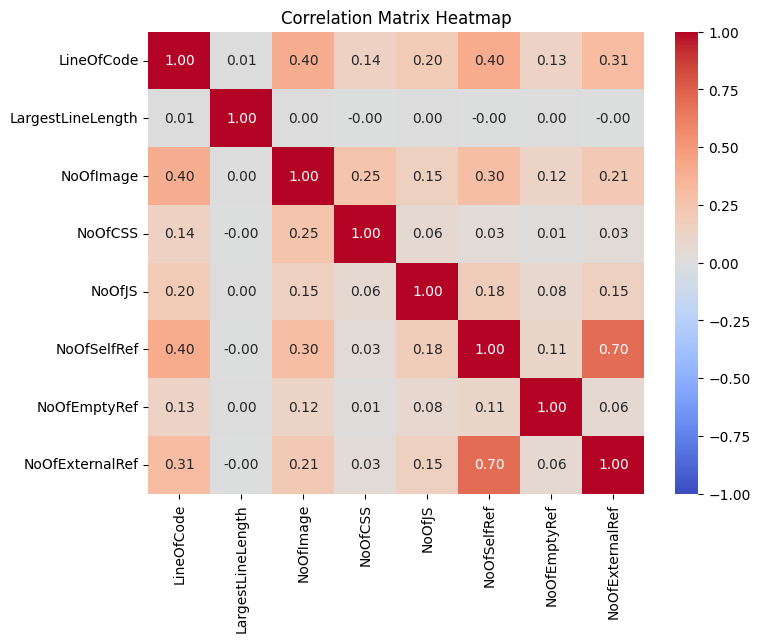

In [12]:
web_page_content = [
    'LineOfCode', 'LargestLineLength', 'NoOfImage', 'NoOfCSS',
    'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef'
]
assembler = VectorAssembler(inputCols=web_page_content, outputCol='features')
assembled_df = assembler.transform(df)

# Compute the correlation matrix
corr_matrix = Correlation.corr(assembled_df, 'features', method='pearson').head()[0]

# Convert the correlation matrix to a dense numpy array for plotting
correlation_matrix = corr_matrix.toArray()

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            xticklabels=web_page_content, yticklabels=web_page_content)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 4. Web Page Features

Using this correlation matrix for the specified web page features helps identify relationships between attributes, such as how the presence of a title or favicon may influence user engagement and SEO performance. This analysis can reveal patterns that inform design decisions, ensuring that key elements are optimized for better usability. Additionally, it can highlight potential security vulnerabilities by showing correlations with features that may indicate risks. Overall, it serves as a valuable tool for data-driven improvements in web development and security practices.

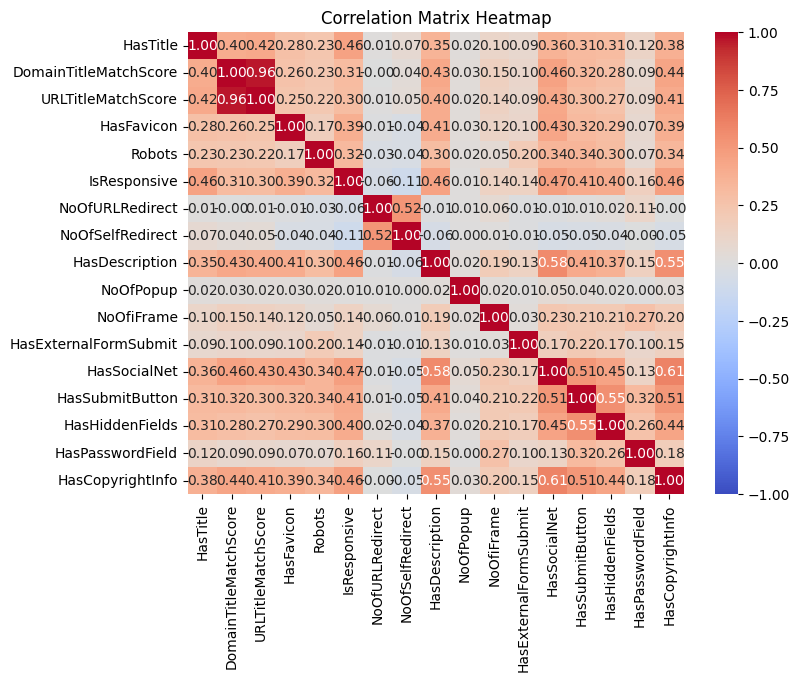

In [13]:
web_page_features = [
    'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon',
    'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect',
    'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit',
    'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField',
    'HasCopyrightInfo'
]
assembler = VectorAssembler(inputCols=web_page_features, outputCol='features')
assembled_df = assembler.transform(df)

# Compute the correlation matrix
corr_matrix = Correlation.corr(assembled_df, 'features', method='pearson').head()[0]

# Convert the correlation matrix to a dense numpy array for plotting
correlation_matrix = corr_matrix.toArray()

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            xticklabels=web_page_features, yticklabels=web_page_features)
plt.title('Correlation Matrix Heatmap')
plt.show()

## URL Structure Analysis

* **URL Length:** Analysing the distribution of URL lengths (e.g., average, max, min) to see if phishing URLs tend to be longer or shorter compared to legitimate ones.
* **Domain Length:** Similar to URL length, check the distribution of domain lengths. Phishing URLs may use longer or shorter domains to obfuscate their intent.
* **Top-Level Domain (TLD) Analysis:** Investigate which TLDs (e.g., .com, .net, .uk) are more commonly used by phishing URLs. Phishing domains may prefer certain TLDs that are cheaper or easier to acquire.
* **Subdomain Usage:** Analyze the number of subdomains. Phishing URLs often hide their malicious intent in lengthy or complex subdomain structures.
* **Use of IP in Domain:** Check how often the domain is an IP address (binary flag IsDomainIP). Phishing URLs sometimes use IPs to avoid being flagged as suspicious.


In [14]:
def basic_stats_and_plots(df, column, label_column=None, title=""):
  # Basic stats
  stats = df.agg(
    mean(col(column)).alias('mean'),
    stddev(col(column)).alias('stddev')
  ).collect()[0]

  # Print the basic statistics
  print(f"{column} Stats:")
  print(f"Mean: {stats['mean']}")
  print(f"Standard Deviation: {stats['stddev']}")

  # Visualization
  plt.figure(figsize=(8, 6))
  if label_column:
      # Get the data for the boxplot using PySpark's select() and collect()
      box_data = df.select(column, label_column).rdd.map(lambda x: (x[column], x[label_column])).collect()

      # Unpack the data
      column_data, label_data = zip(*box_data)

      # Create the boxplot
      sns.boxplot(x=label_data, y=column_data)
  else:
      # Histogram + KDE plot
      # Convert the specific column to a list (avoid full DataFrame to Pandas conversion)
      column_data = df.select(column).rdd.flatMap(lambda x: x).collect()
      sns.histplot(column_data, kde=True)

  plt.title(title)
  plt.show()

## Frequency of TLDs (Top-level domains)
---
The plot shows the distribution of different TLDs used in the URLs. Some common TLDs like .com, .org, and .uk are frequent. This metric can hint whether certain TLDs are more associated with phishing.

In [15]:
# Calculate the frequency of each TLD
# tld_counts = df['TLD'].value_counts()
# tld_counts

TypeError: 'Column' object is not callable

## Hypothesis 1
---
**URL Length and Phishing Likelihood**
Longer URLs may increase the likelihood of phishing attempts, as they can obscure the true destination and include misleading information. Phishers often use lengthy URLs to hide malicious domains within a sea of characters, making detection harder for users. Conversely, shorter, more straightforward URLs are typically associated with legitimate sites, enhancing user trust. Thus, analyzing URL length could be a valuable indicator in phishing detection models.

URLLength Stats:
Mean: 34.57309527343667
Standard Deviation: 41.31415267798631


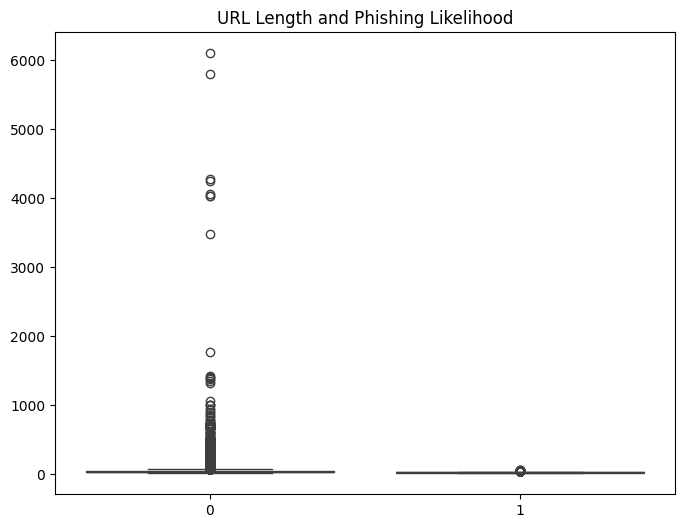

In [16]:
basic_stats_and_plots(df, 'URLLength', label_column='label', title="URL Length and Phishing Likelihood")

## Hypothesis 2
---
**Domain Characteristics and Legitimacy**
Shorter domain names are often perceived as more legitimate and trustworthy, as they tend to be easier to remember and type. In contrast, longer domain names may raise suspicion, as they can appear convoluted or spammy. Additionally, domains that closely resemble established brands but are excessively long may indicate potential phishing attempts. Therefore, analyzing domain length could serve as a useful metric in assessing a website’s legitimacy.

DomainLength Stats:
Mean: 21.470395894739074
Standard Deviation: 9.15079322392256


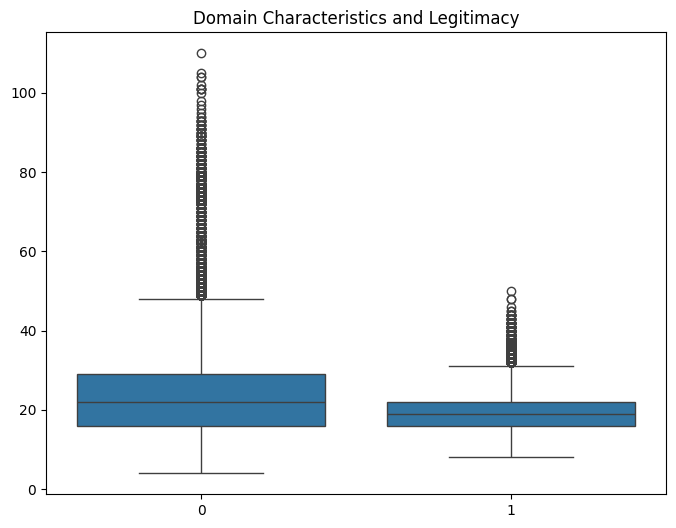

In [17]:
basic_stats_and_plots(df, 'DomainLength', label_column='label', title='Domain Characteristics and Legitimacy')

## Hypothesis 3
---
 **Top-Level Domain (TLD) Influence**
The Top-Level Domain (TLD) significantly influences the likelihood of phishing attacks, with certain TLDs being more frequently exploited by cybercriminals. Research indicates that TLDs such as google, .gov, edu, .ml, and .ga are among the top offenders, often associated with over 90% of phishing attempts. In contrast, more established TLDs like .com and .net generally exhibit lower phishing ratios. This correlation underscores the importance of TLD analysis in enhancing phishing detection and prevention strategies.

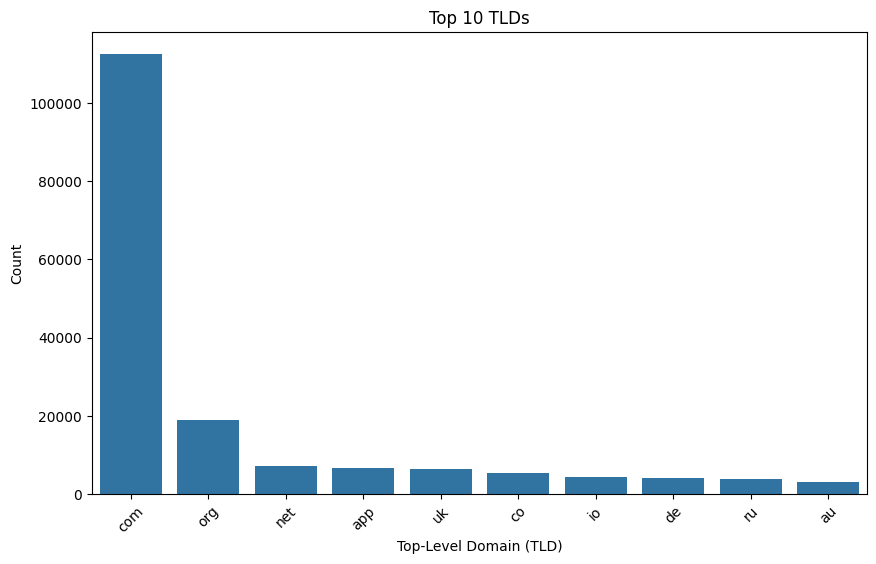

In [18]:
tld_counts = df.groupBy("TLD").count().orderBy(col("count").desc()).limit(10)

# Collect the results as a list of Row objects
tld_list = tld_counts.rdd.map(lambda row: (row['TLD'], row['count'])).collect()

# Unpack the list of tuples into two separate lists: TLDs and counts
tlds, counts = zip(*tld_list)

# Plot the results using Matplotlib/Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=list(tlds), y=list(counts))
plt.title('Top 10 TLDs')
plt.xlabel('Top-Level Domain (TLD)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Hypothesis 4
---
 **HTTPS Usage**
 The usage of HTTPS is a critical factor in distinguishing between phishing and non-phishing URLs, as legitimate sites typically employ HTTPS to secure user data. Phishing sites often use HTTP to create a false sense of security, but many are increasingly adopting HTTPS to appear more credible. However, the presence of HTTPS alone does not guarantee legitimacy, as attackers can easily obtain SSL certificates. Thus, analyzing HTTPS usage alongside other indicators is essential for effective phishing detection.

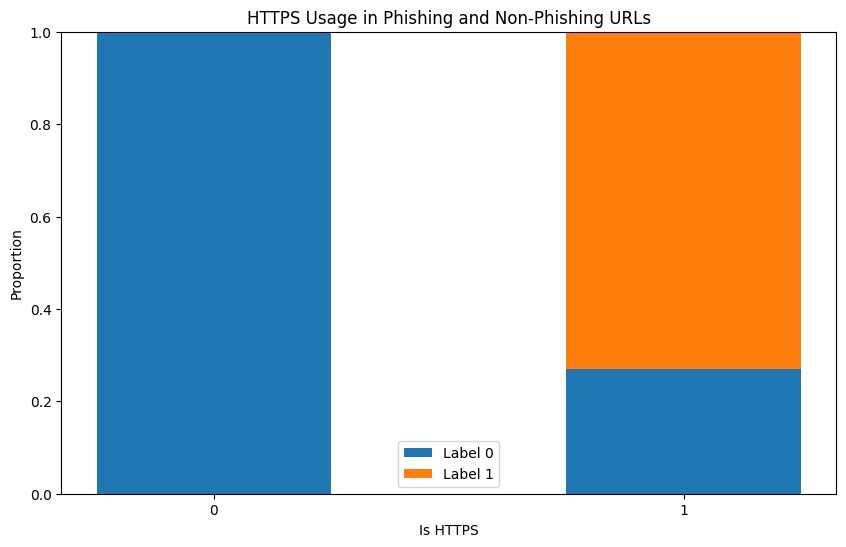

In [25]:
# Group by 'IsHTTPS' and 'label', and calculate counts
grouped = df.groupBy('IsHTTPS', 'label').count()

# Calculate the total counts for each 'IsHTTPS'
total_counts = grouped.groupBy('IsHTTPS').agg(sum('count').alias('total_count'))

# Join to calculate the proportions
proportions = grouped.join(total_counts, on='IsHTTPS') \
                     .withColumn('proportion', col('count') / col('total_count')) \
                     .select('IsHTTPS', 'label', 'proportion')

pivoted = proportions.groupBy('IsHTTPS').pivot('label').agg(first('proportion'))

# Step 4: Collect data for plotting
plot_data = proportions.collect()

# Step 5: Restructure data for plotting
# Build a dictionary: {IsHTTPS: {label: proportion}}
data_dict = {}
for row in plot_data:
    is_https = row['IsHTTPS']
    label = row['label']
    proportion = row['proportion']
    if is_https not in data_dict:
        data_dict[is_https] = {}
    data_dict[is_https][label] = proportion

# Fill missing labels with 0
all_labels = sorted({row['label'] for row in plot_data})  # Ensure sorted for consistent order
categories = sorted(data_dict.keys())  # Ensure sorted for consistent order
plot_values = []

for category in categories:
    values = [data_dict[category].get(label, 0) for label in all_labels]
    plot_values.append(values)

# Step 6: Prepare data for plotting
# Prepare x-axis labels
x_positions = list(range(len(categories)))

# Step 7: Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5

# Stack the bars
bottom_values = [0] * len(categories)
for i, label in enumerate(all_labels):
    bar_heights = [values[i] for values in plot_values]
    ax.bar(x_positions, bar_heights, bar_width, bottom=bottom_values, label=f"Label {label}")
    # Update bottom values for stacking
    bottom_values = [bottom + height for bottom, height in zip(bottom_values, bar_heights)]

# Add titles and labels
ax.set_title('HTTPS Usage in Phishing and Non-Phishing URLs')
ax.set_xlabel('Is HTTPS')
ax.set_ylabel('Proportion')
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


## Hypothesis 5
---
 **Obfuscation Techniques**
 Obfuscation techniques are commonly employed in phishing URLs to disguise malicious intent and mislead users. Phishing sites often use tactics such as URL shortening, character substitution, and misleading subdomains to create a façade of legitimacy. In contrast, non-phishing URLs typically maintain clear and straightforward structures that reflect their true purpose. Analyzing the presence and type of obfuscation can be crucial in distinguishing between phishing and legitimate websites.

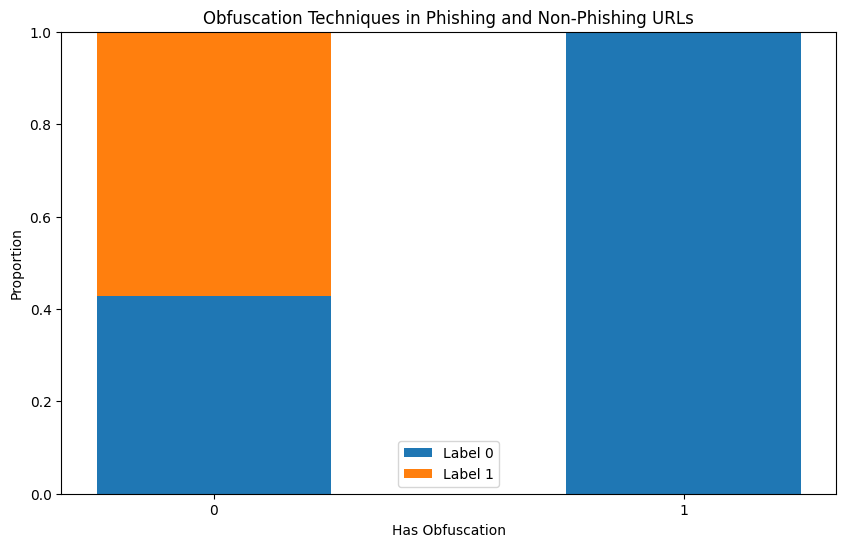

In [26]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Group by 'HasObfuscation' and 'label', and calculate counts
grouped = df.groupBy('HasObfuscation', 'label').count()

# Step 2: Calculate the total counts for each 'HasObfuscation'
total_counts = grouped.groupBy('HasObfuscation').agg(sum('count').alias('total_count'))

# Step 3: Join to calculate proportions
proportions = grouped.join(total_counts, on='HasObfuscation') \
                     .withColumn('proportion', col('count') / col('total_count')) \
                     .select('HasObfuscation', 'label', 'proportion')

# Step 4: Collect data for plotting
plot_data = proportions.collect()

# Step 5: Restructure data for plotting
# Build a dictionary: {HasObfuscation: {label: proportion}}
data_dict = {}
for row in plot_data:
    has_obfuscation = row['HasObfuscation']
    label = row['label']
    proportion = row['proportion']
    if has_obfuscation not in data_dict:
        data_dict[has_obfuscation] = {}
    data_dict[has_obfuscation][label] = proportion

# Fill missing labels with 0
all_labels = sorted({row['label'] for row in plot_data})  # Ensure sorted for consistent order
categories = sorted(data_dict.keys())  # Ensure sorted for consistent order
plot_values = []

for category in categories:
    values = [data_dict[category].get(label, 0) for label in all_labels]
    plot_values.append(values)

# Step 6: Prepare data for plotting
# Prepare x-axis labels
x_positions = list(range(len(categories)))

# Step 7: Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5

# Stack the bars
bottom_values = [0] * len(categories)
for i, label in enumerate(all_labels):
    bar_heights = [values[i] for values in plot_values]
    ax.bar(x_positions, bar_heights, bar_width, bottom=bottom_values, label=f"Label {label}")
    # Update bottom values for stacking
    bottom_values = [bottom + height for bottom, height in zip(bottom_values, bar_heights)]

# Add titles and labels
ax.set_title('Obfuscation Techniques in Phishing and Non-Phishing URLs')
ax.set_xlabel('Has Obfuscation')
ax.set_ylabel('Proportion')
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


## Hypothesis 6
---
 **Content Features**
 The number of images, CSS files, and JavaScript (JS) files on a webpage can influence its likelihood of being a phishing site. Phishing pages often have fewer images and rely heavily on minimalistic designs to quickly load and deceive users. Conversely, legitimate websites typically use a balanced mix of content, including multiple images and well-structured CSS and JS files for enhanced functionality and aesthetics. Analyzing these elements can provide valuable insights into the potential phishing nature of a site.

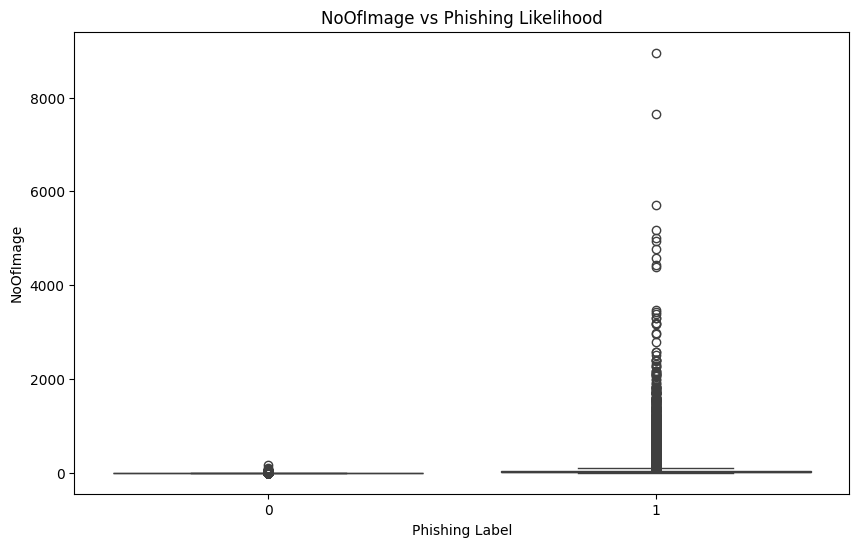

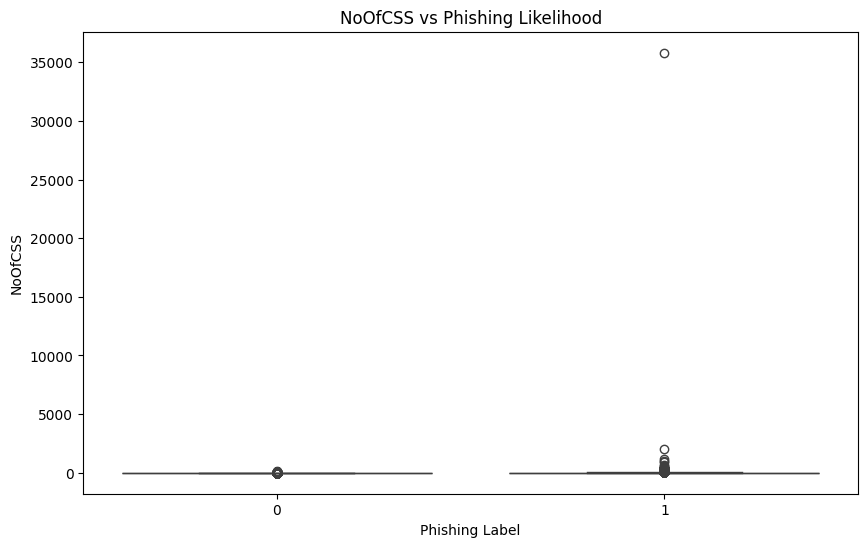

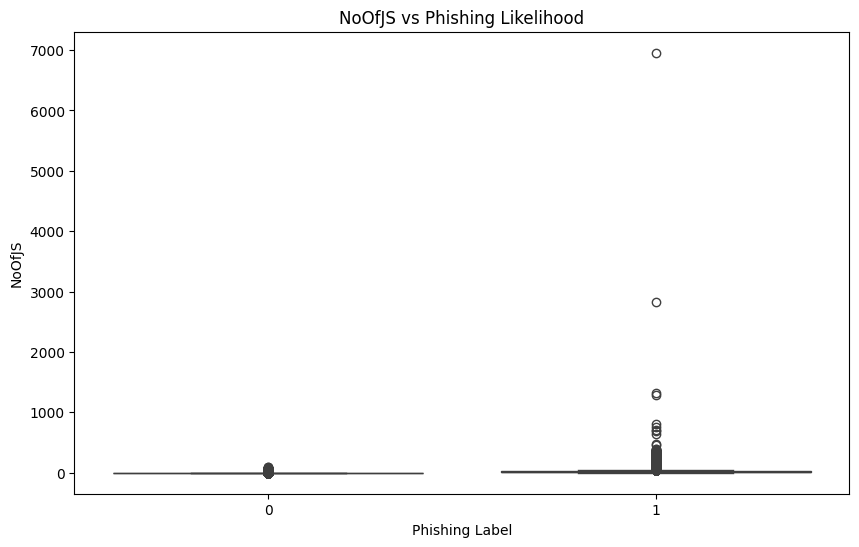

In [27]:

# Features to analyze
content_features = ['NoOfImage', 'NoOfCSS', 'NoOfJS']

# Iterate over each feature to generate boxplots
for feature in content_features:
    # Step 1: Collect data for plotting
    plot_data = df.select('label', feature).collect()  # Collect the required columns

    # Step 2: Restructure data for plotting
    labels = []
    feature_values = []

    for row in plot_data:
        labels.append(row['label'])
        feature_values.append(row[feature])

    # Step 3: Prepare data for Seaborn
    # Seaborn requires tabular data, so construct a dictionary for visualization
    data_for_plotting = {
        'label': labels,
        feature: feature_values
    }

    # Step 4: Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_for_plotting['label'], y=data_for_plotting[feature])
    plt.title(f'{feature} vs Phishing Likelihood')
    plt.xlabel('Phishing Label')
    plt.ylabel(feature)
    plt.show()



## Hypothesis 7
---
 **Social Network Links**
 The presence of social network links on a webpage can be a significant indicator of its legitimacy, with phishing sites often lacking these links or using them deceptively. Legitimate websites typically include authentic social media profiles to build trust and engage with users, while phishing sites may either omit these links or link to fake accounts. Additionally, phishing URLs might use social media icons to create a false sense of credibility without actual connections. Analyzing the presence and authenticity of social network links can enhance the detection of phishing attempts.


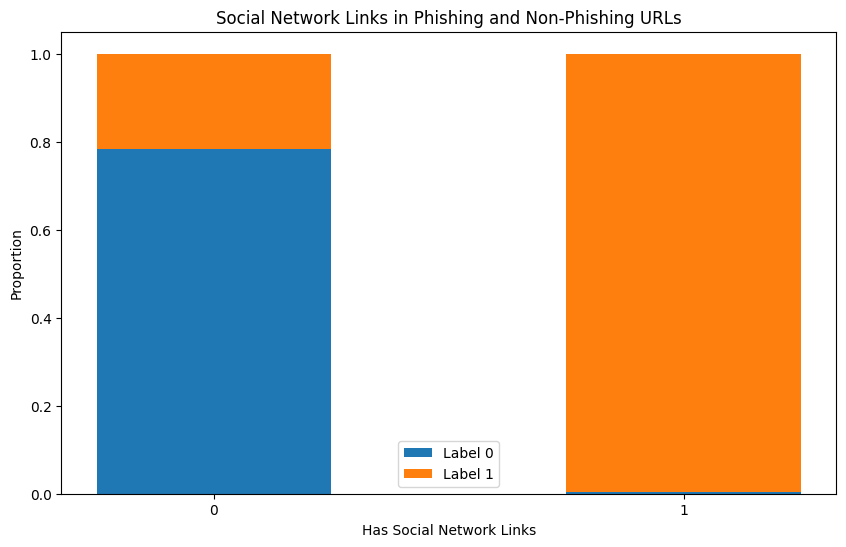

In [29]:
# Step 1: Group by 'HasSocialNet' and 'label', and calculate counts
grouped = df.groupBy('HasSocialNet', 'label').count()

# Step 2: Calculate the total counts for each 'HasSocialNet'
total_counts = grouped.groupBy('HasSocialNet').agg(sum('count').alias('total_count'))

# Step 3: Join to calculate proportions
proportions = grouped.join(total_counts, on='HasSocialNet') \
                     .withColumn('proportion', col('count') / col('total_count')) \
                     .select('HasSocialNet', 'label', 'proportion')

# Step 4: Collect data for plotting
plot_data = proportions.collect()

# Step 5: Restructure data for plotting
# Build a dictionary: {HasSocialNet: {label: proportion}}
data_dict = {}
for row in plot_data:
    has_social_net = row['HasSocialNet']
    label = row['label']
    proportion = row['proportion']
    if has_social_net not in data_dict:
        data_dict[has_social_net] = {}
    data_dict[has_social_net][label] = proportion

# Fill missing labels with 0
all_labels = sorted({row['label'] for row in plot_data})  # Ensure sorted for consistent order
categories = sorted(data_dict.keys())  # Ensure sorted for consistent order
plot_values = []

for category in categories:
    values = [data_dict[category].get(label, 0) for label in all_labels]
    plot_values.append(values)

# Step 6: Prepare data for plotting
# Prepare x-axis labels
x_positions = list(range(len(categories)))

# Step 7: Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5

# Stack the bars
bottom_values = [0] * len(categories)
for i, label in enumerate(all_labels):
    bar_heights = [values[i] for values in plot_values]
    ax.bar(x_positions, bar_heights, bar_width, bottom=bottom_values, label=f"Label {label}")
    # Update bottom values for stacking
    bottom_values = [bottom + height for bottom, height in zip(bottom_values, bar_heights)]

# Add titles and labels
ax.set_title('Social Network Links in Phishing and Non-Phishing URLs')
ax.set_xlabel('Has Social Network Links')
ax.set_ylabel('Proportion')
ax.set_xticks(x_positions)
ax.set_xticklabels(categories)
ax.legend()

plt.show()


## Hypothesis 8
---
 **Redirects and Popups**
 The number of URL redirects and popups on a webpage can significantly indicate its phishing likelihood. Phishing sites often employ multiple redirects to obscure their true destination and create confusion, while excessive popups can be used to pressure users into providing sensitive information. In contrast, legitimate websites typically have minimal redirects and controlled popup usage to enhance user experience. Analyzing these factors can help identify potentially malicious sites more effectively.



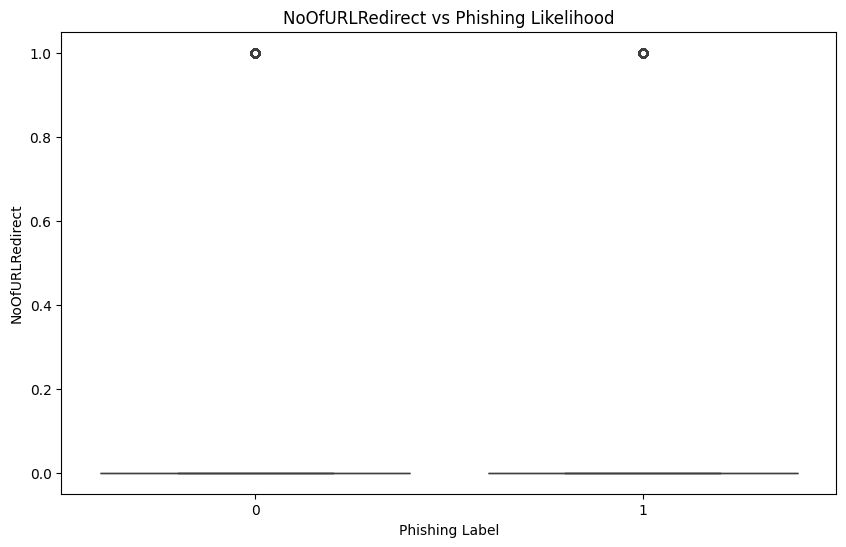

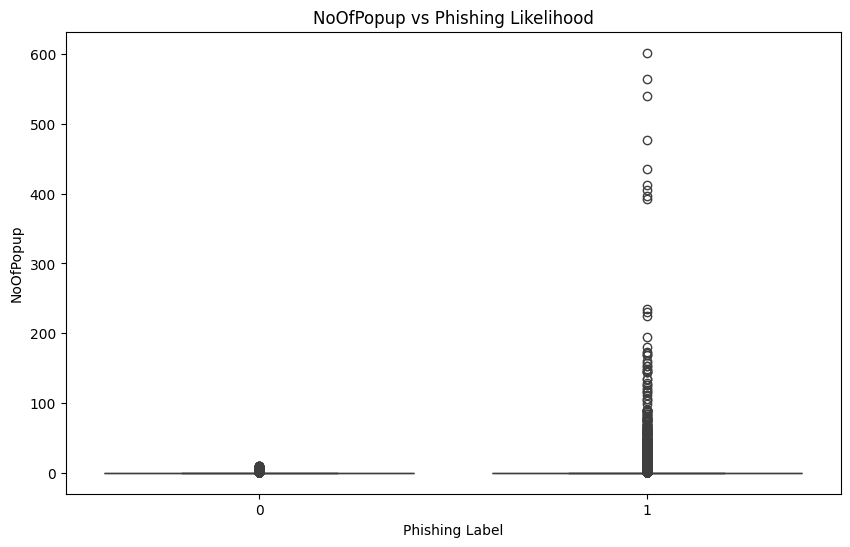

In [30]:
# Features to analyze
redirects_popups = ['NoOfURLRedirect', 'NoOfPopup']

# Iterate over each feature to generate boxplots
for feature in redirects_popups:
    # Step 1: Collect data for plotting
    plot_data = df.select('label', feature).collect()  # Collect the required columns

    # Step 2: Restructure data for plotting
    labels = []
    feature_values = []

    for row in plot_data:
        labels.append(row['label'])
        feature_values.append(row[feature])

    # Step 3: Prepare data for Seaborn
    # Seaborn requires tabular data, so construct a dictionary for visualization
    data_for_plotting = {
        'label': labels,
        feature: feature_values
    }

    # Step 4: Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_for_plotting['label'], y=data_for_plotting[feature])
    plt.title(f'{feature} vs Phishing Likelihood')
    plt.xlabel('Phishing Label')
    plt.ylabel(feature)
    plt.show()
